# <center>**Bioseñales y sistemas**
## <center>**Proyecto procesamiento de señales EMG**
## <center>**Seguimiento 4**
#### Maria Alejandra Escobar - C.C 1004425012
#### Juan Manuel Martínez - C.C 1007739919

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal

In [294]:
import os
import glob
ruta_p = 'EMG_data_for_gestures-master'
i = 0
diccionario_3d = {} 
for carpeta in os.listdir(ruta_p):
    i+=1
    carpeta_path = os.path.join(ruta_p, carpeta)
    archivos = glob.glob(os.path.join(carpeta_path, '*'))
    if len(archivos)>0:
        primer_archivo = archivos[0]
        df = pd.read_csv(primer_archivo, delimiter="\t")
        diccionario_3d[i] = df

In [295]:
def tkeo(a):
    a = np.array(a)
    aTkeo = np.zeros_like(a)  # Crear un vector del mismo tamaño lleno de ceros
    i = a[1:-1] * a[1:-1]
    j = a[2:] * a[:-2]
    aTkeo[1:-1] = i - j  # Copiar los valores calculados al vector original
    return aTkeo

In [296]:
def tkeo_multiple(df):
    df_nuevo = df.copy()
    for i in range(8):
        arreglo = np.array(df_nuevo[f'channel{i+1}'])
        ar_tkeo = tkeo(arreglo)
        df_nuevo[f'channel{i+1}'] = ar_tkeo
    return df_nuevo

Para el filtro, se determino utilizar un pasa banda, conformado por un pasa altas a 10 Hz con una banda de atenuacion de 10 Hz y un pasa bajas con frecuencia de corte de 50 Hz y banda de atenuacion de 10 Hz, lo cual arroja un orden para ambos filtros de 33. 

El dispositivo utilizado para la toma de las senales del datased es un MYO armband, el cual cuenta con una frecuencia de muestreo para EMG de superficie de 200 Hz 

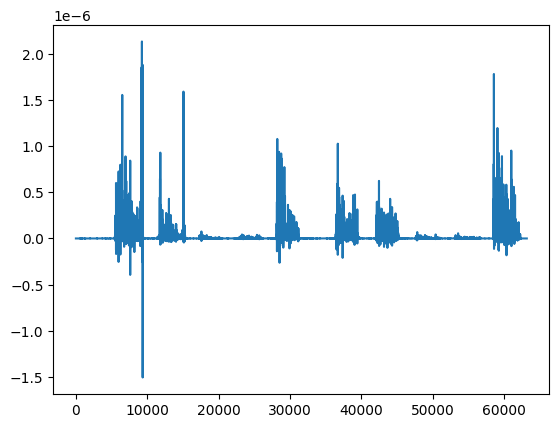

In [297]:
df_tkeo = tkeo_multiple(diccionario_3d[1])
plt.plot(df_tkeo['channel1'])

In [298]:
fs = 200
orden = 32
wn_baja = 10/(fs/2)
wn_alta = 40/(fs/2)
pasaBaja_Fiir = signal.firwin(orden+1, wn_alta, pass_zero = 'lowpass',window='hamming')
pasaAltas_Fiir = signal.firwin(orden+1, wn_baja, pass_zero = 'highpass',window='hamming')

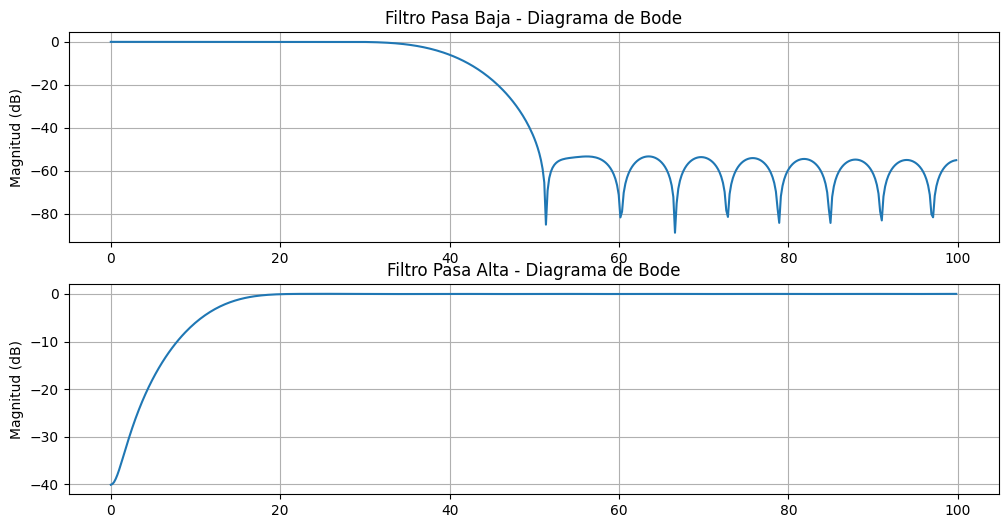

In [299]:
w_baja, h_baja = signal.freqz(pasaBaja_Fiir, fs=fs)
w_alta, h_alta = signal.freqz(pasaAltas_Fiir, fs=fs)


plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(w_baja, 20 * np.log10(abs(h_baja)))
plt.title('Filtro Pasa Baja - Diagrama de Bode')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(w_alta, 20 * np.log10(abs(h_alta)))
plt.title('Filtro Pasa Alta - Diagrama de Bode')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

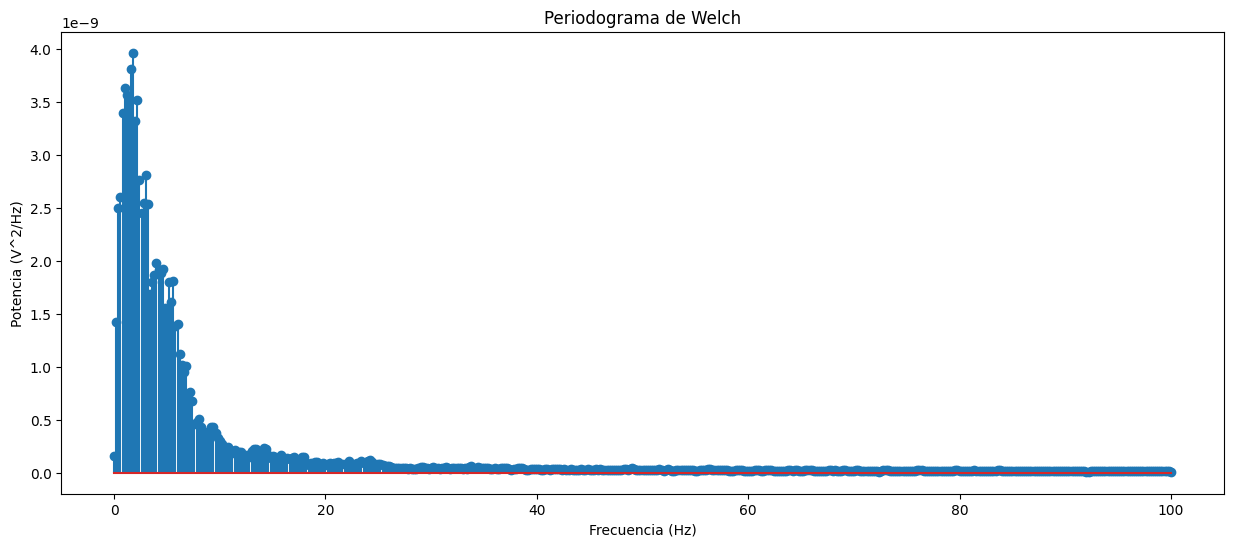

In [300]:
from scipy.signal import welch
from scipy.signal import windows

fs = 200
window_size = 1000  # Tamaño de la ventana de 2000 muestras
overlap = window_size // 2  # Solapamiento del 50%
window = windows.hamming(window_size)

# Periodograma de Welch
f, pxx = welch(diccionario_3d[1]['channel1'], fs=fs, window=window, nperseg=window_size, noverlap=overlap)

plt.figure(figsize=(15, 6))
plt.stem(f, pxx)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.title('Periodograma de Welch')
plt.show()

In [301]:
def filtrar_multicanal(df):
    df_nuevo = df.copy()
    for i in range(8):
        senal = np.array(df_nuevo[f'channel{i+1}'])
        signal_filt = signal.filtfilt(b=pasaBaja_Fiir,a=1,x=senal)
        signal_filtt = signal.filtfilt(b=pasaAltas_Fiir,a=1,x=signal_filt)
        df_nuevo[f'channel{i+1}'] = signal_filtt
    return df_nuevo
    
        

In [302]:

df_filt = filtrar_multicanal(df_tkeo)

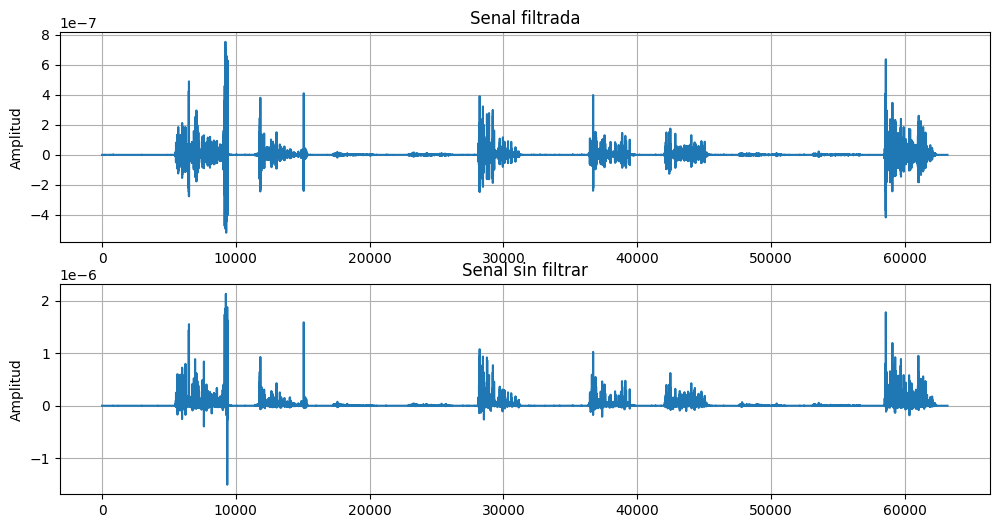

In [303]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df_filt['channel1'])
plt.title('Senal filtrada')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_tkeo['channel1'])
plt.title('Senal sin filtrar')
plt.ylabel('Amplitud')
plt.grid(True)

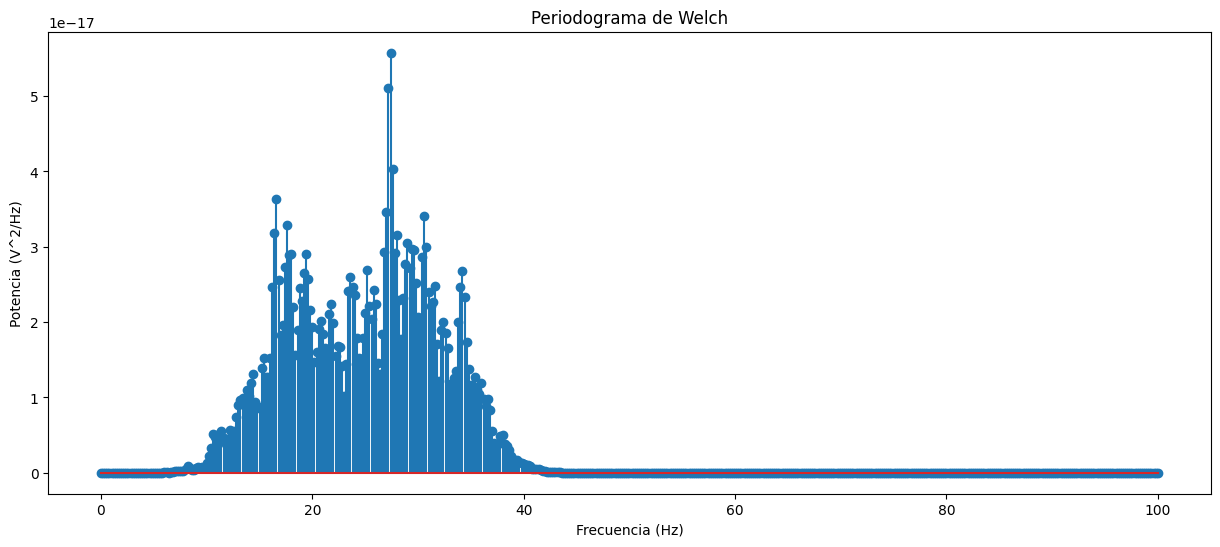

In [304]:
f, pxx = welch(df_filt['channel1'], fs=fs, window=window, nperseg=window_size, noverlap=overlap)
plt.figure(figsize=(15, 6))
plt.stem(f, pxx)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.title('Periodograma de Welch')
plt.show()


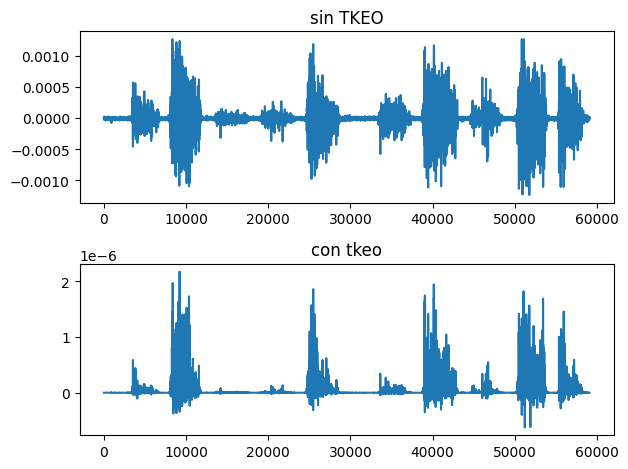

In [305]:
diccionario_Tkeo = {}
i = 0
for pac in diccionario_3d.values():
    i+=1
    diccionario_Tkeo[i] = tkeo_multiple(pac)

plt.figure()  

plt.subplot(2, 1, 1)
plt.plot(diccionario_3d[4]['channel1'])
plt.title('sin TKEO')

plt.subplot(2, 1, 2)
plt.plot(diccionario_Tkeo[4]['channel1'])
plt.title('con tkeo')

plt.tight_layout()

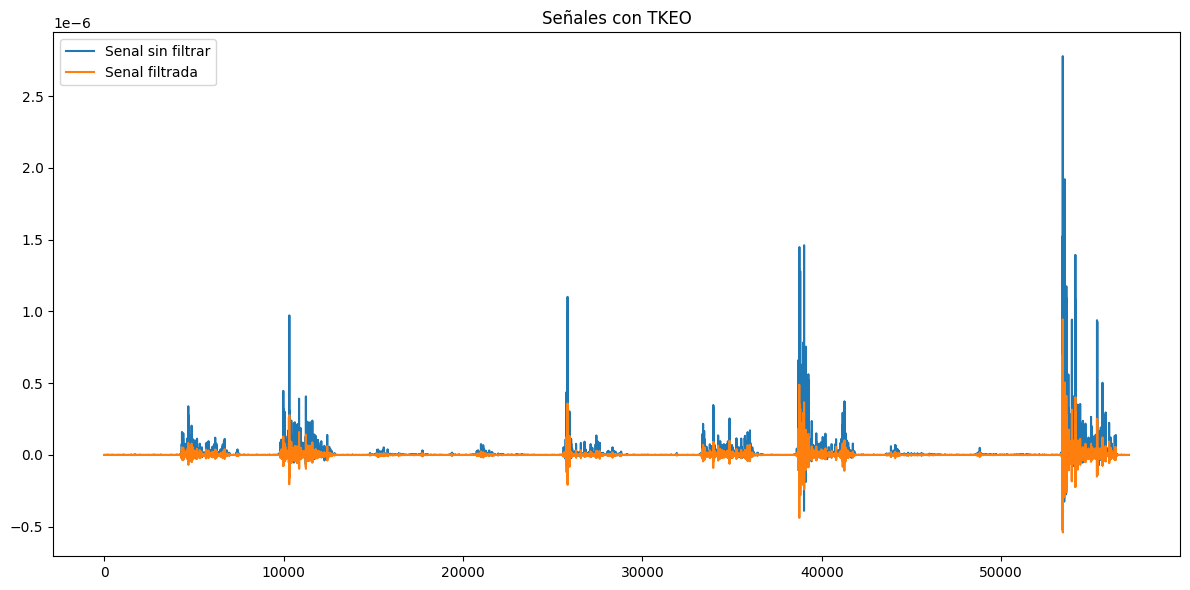

In [310]:
diccionario_Tkeo_filt = {}
i = 0
for pac in diccionario_Tkeo.values():
    i+=1
    diccionario_Tkeo_filt[i] = filtrar_multicanal(pac)

plt.figure(figsize=(12, 6))  

plt.plot(diccionario_Tkeo[5]['channel1'],label = 'Senal sin filtrar')
plt.plot(diccionario_Tkeo_filt[5]['channel1'], label = 'Senal filtrada')
plt.title('Señales con TKEO')
plt.legend()

plt.tight_layout()

In [319]:
def calcularRMS(X):
  N=X.size #Cantidad de puntos
  rms=(np.sum(X**(2))/N)**0.5
  return rms

In [320]:
def var_est(df):
    res_canales_list = []
    estadisticas = ['class','C_1RMS', 'C_1Var', 'C_1MAV', 'C_1MAVS', 'C_1SSC', 'C_1WL', 'C_1ZC',
                    'C_2RMS', 'C_2Var', 'C_2MAV', 'C_2MAVS', 'C_2SSC', 'C_2WL', 'C_2ZC',
                    'C_3RMS', 'C_3Var', 'C_3MAV', 'C_3MAVS', 'C_3SSC', 'C_3WL', 'C_3ZC',
                    'C_4RMS', 'C_4Var', 'C_4MAV', 'C_4MAVS', 'C_4SSC', 'C_4WL', 'C_4ZC',
                    'C_5RMS', 'C_5Var', 'C_5MAV', 'C_5MAVS', 'C_5SSC', 'C_5WL', 'C_5ZC',
                    'C_6RMS', 'C_6Var', 'C_6MAV', 'C_6MAVS', 'C_6SSC', 'C_6WL', 'C_6ZC',
                    'C_7RMS', 'C_7Var', 'C_7MAV', 'C_7MAVS', 'C_7SSC', 'C_7WL', 'C_7ZC',
                    'C_8RMS', 'C_8Var', 'C_8MAV', 'C_8MAVS', 'C_8SSC', 'C_8WL', 'C_8ZC']
    clase = []
    for i in range(8):
        clase = [i]
        lista_move = [] 
        df_p1 = df[df['class'] == i] 
        for j in range(8):
            arreglo = np.array(df_p1[f'channel{j+1}'])
            rms = calcularRMS(arreglo)
            var = np.var(arreglo)
            mean = np.mean(np.abs(arreglo))
            mean_slope = np.mean(np.abs(np.diff(arreglo)))
            sl_sign_c = np.sum(np.abs(np.diff(np.sign(np.diff(arreglo)))))
            wl_values = np.sum(np.abs(np.diff(arreglo)))
            zero_crossings = np.sum(np.diff(np.sign(arreglo)))
            lista = [rms, var, mean, mean_slope, sl_sign_c, wl_values, zero_crossings]
            lista_move.extend(lista)
        
        clase.extend(lista_move)        
        res_canales_list.append(clase)
        
    df_estadisticas = pd.DataFrame(res_canales_list, columns=estadisticas)
    return df_estadisticas

In [327]:
def build_final_df(diccionario):
    i = 0
    df_final_Tkeo = pd.DataFrame()
    for pac in diccionario.values():
        i+=1
        df_np = pd.DataFrame({'Sujeto': (np.ones(8, dtype=int))* i,'class': np.arange(0, 8)})
        df_final = var_est(pac)
        df_final = pd.merge(df_np, df_final, how = 'left', on = 'class')
        df_final_Tkeo = pd.concat([df_final_Tkeo,df_final],axis=0)
        df_final_Tkeo = df_final_Tkeo.fillna(0)
    return df_final_Tkeo
      

In [330]:
df_final_Tkeo = build_final_df(diccionario_Tkeo)
df_final_Tkeo_filt = build_final_df(diccionario_Tkeo_filt)

C:\Users\Juan Manuel\AppData\Local\Temp\ipykernel_24132\2966749409.py:3: RuntimeWarning: invalid value encountered in scalar divide
  rms=(np.sum(X**(2))/N)**0.5
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / r

In [331]:
df_final_Tkeo

,Sujeto,class,C_1RMS,C_1Var,C_1MAV,C_1MAVS,C_1SSC,C_1WL,C_1ZC,C_2RMS,...,C_7SSC,C_7WL,C_7ZC,C_8RMS,C_8Var,C_8MAV,C_8MAVS,C_8SSC,C_8WL,C_8ZC
0,1,0,4.949585e-08,2.436138e-15,4.238573e-09,6.380805e-09,13795.0,2.633422e-04,0.0,4.706363e-08,...,13620.0,2.641450e-04,0.0,5.159534e-08,2.646441e-15,4.592738e-09,6.975053e-09,13777.0,2.878674e-04,0.0
1,1,1,2.036246e-10,4.021190e-20,4.505291e-11,7.700450e-11,1150.0,2.910000e-07,0.0,6.175412e-10,...,1123.0,2.062000e-07,1.0,1.452875e-10,2.042391e-20,3.373016e-11,5.856047e-11,1181.0,2.213000e-07,-1.0
2,1,2,6.102474e-08,3.624883e-15,1.171336e-08,1.747182e-08,1279.0,6.157070e-05,1.0,1.394133e-08,...,1245.0,5.259270e-05,-1.0,2.615771e-08,6.601893e-16,5.615915e-09,8.235953e-09,1201.0,2.902350e-05,1.0
3,1,3,2.883578e-08,8.014632e-16,6.422799e-09,9.658087e-09,1298.0,3.684560e-05,0.0,4.346832e-08,...,1236.0,6.412800e-06,0.0,2.221483e-08,4.761333e-16,4.738208e-09,6.765557e-09,1282.0,2.581060e-05,0.0
4,1,4,2.415744e-09,5.625702e-18,5.387678e-10,7.895349e-10,1196.0,2.716000e-06,0.0,7.663082e-09,...,1204.0,1.223960e-05,0.0,5.051364e-09,2.468358e-17,1.083697e-09,1.603198e-09,1200.0,5.515000e-06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,36,3,4.020941e-08,1.563179e-15,8.440877e-09,1.219961e-08,1127.0,3.756260e-05,1.0,1.175082e-08,...,1107.0,6.995000e-06,1.0,6.531037e-09,4.082018e-17,1.539675e-09,2.197272e-09,1111.0,6.765400e-06,-1.0
4,36,4,1.850992e-09,3.288742e-18,4.300410e-10,6.212121e-10,1146.0,1.968000e-06,0.0,2.763945e-09,...,1164.0,5.445200e-06,0.0,1.902917e-09,3.445692e-18,4.757337e-10,6.991162e-10,1154.0,2.214800e-06,0.0
5,36,5,2.276129e-08,4.958364e-16,5.403088e-09,7.866903e-09,1072.0,2.215320e-05,0.0,2.193065e-08,...,986.0,1.236200e-06,0.0,1.248609e-09,1.501930e-18,2.828186e-10,4.254261e-10,992.0,1.198000e-06,0.0
6,36,6,1.184596e-08,1.353901e-16,2.510870e-09,3.747448e-09,1109.0,1.071770e-05,1.0,3.690457e-09,...,1159.0,1.039000e-05,-1.0,1.849131e-08,3.289931e-16,4.012513e-09,5.814580e-09,1117.0,1.662970e-05,-1.0


In [332]:
df_final_Tkeo_filt

,Sujeto,class,C_1RMS,C_1Var,C_1MAV,C_1MAVS,C_1SSC,C_1WL,C_1ZC,C_2RMS,...,C_7SSC,C_7WL,C_7ZC,C_8RMS,C_8Var,C_8MAV,C_8MAVS,C_8SSC,C_8WL,C_8ZC
0,1,0,2.495527e-08,6.227656e-16,4.690519e-09,3.773200e-09,26318.0,1.557237e-04,0.0,2.383143e-08,...,26424.0,1.520731e-04,2.0,2.528025e-08,6.390912e-16,4.943259e-09,3.983275e-09,26402.0,1.643937e-04,2.0
1,1,1,9.856792e-11,9.715630e-21,4.760260e-11,3.839132e-11,2448.0,1.450808e-07,0.0,2.995875e-10,...,2464.0,9.864386e-08,0.0,6.630441e-11,4.396275e-21,3.408171e-11,2.824280e-11,2414.0,1.067296e-07,-2.0
2,1,2,3.098198e-08,9.598825e-16,1.249268e-08,9.830496e-09,2196.0,3.464267e-05,-2.0,7.894071e-09,...,2220.0,2.976500e-05,-2.0,1.371545e-08,1.881137e-16,6.297821e-09,4.972604e-09,2224.0,1.752346e-05,-2.0
3,1,3,1.486692e-08,2.210254e-16,7.074607e-09,5.713289e-09,2466.0,2.179620e-05,0.0,2.273063e-08,...,2418.0,3.848466e-06,2.0,1.228466e-08,1.509128e-16,5.355145e-09,4.267062e-09,2448.0,1.627884e-05,2.0
4,1,4,1.297642e-09,1.683869e-18,5.874935e-10,4.685314e-10,2192.0,1.611748e-06,2.0,4.064778e-09,...,2180.0,7.137138e-06,2.0,2.634088e-09,6.938418e-18,1.171036e-09,9.297581e-10,2190.0,3.198368e-06,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,36,3,2.134241e-08,4.554898e-16,9.467962e-09,7.392429e-09,1920.0,2.276129e-05,2.0,6.030924e-09,...,1914.0,4.041882e-06,2.0,3.528192e-09,1.244802e-17,1.679516e-09,1.342337e-09,1928.0,4.133056e-06,2.0
4,36,4,1.009567e-09,1.019226e-18,4.617788e-10,3.647492e-10,1986.0,1.155526e-06,0.0,1.519811e-09,...,1974.0,3.330555e-06,-2.0,1.028587e-09,1.057992e-18,5.246074e-10,4.137800e-10,1962.0,1.310855e-06,-2.0
5,36,5,1.174665e-08,1.379831e-16,5.877146e-09,4.581388e-09,1792.0,1.290119e-05,0.0,1.133537e-08,...,1746.0,7.211780e-07,0.0,6.285989e-10,3.951343e-19,3.028874e-10,2.379378e-10,1798.0,6.700330e-07,-2.0
6,36,6,6.021556e-09,3.625914e-17,2.776581e-09,2.187022e-09,1762.0,6.254884e-06,0.0,1.904452e-09,...,1788.0,6.012132e-06,-2.0,9.804704e-09,9.613162e-17,4.577889e-09,3.622354e-09,1804.0,1.035993e-05,-2.0


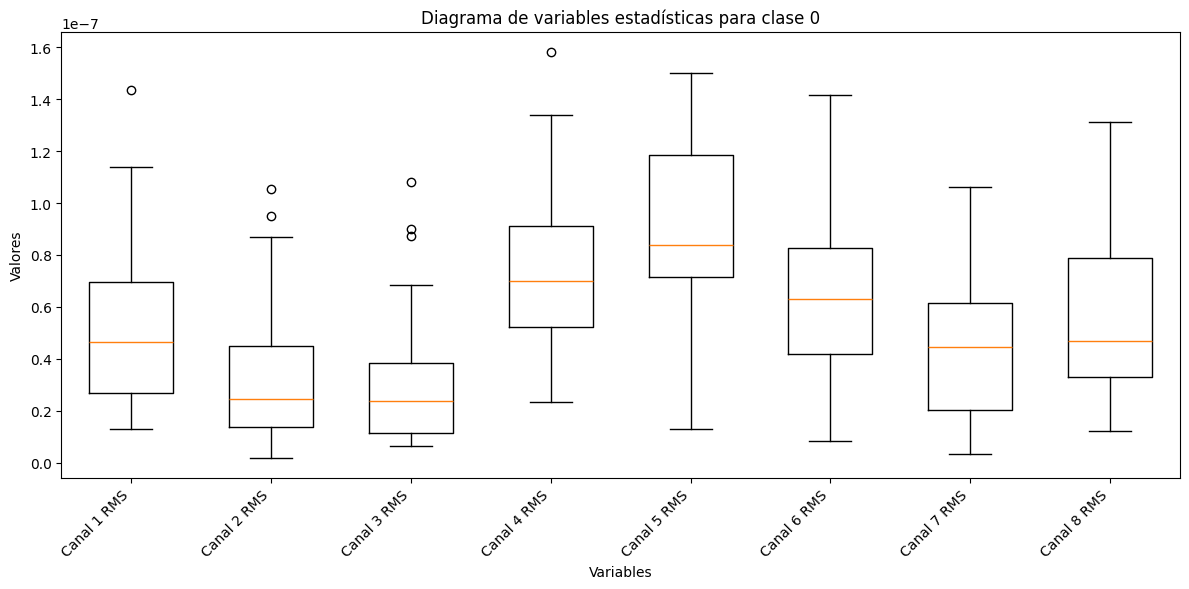

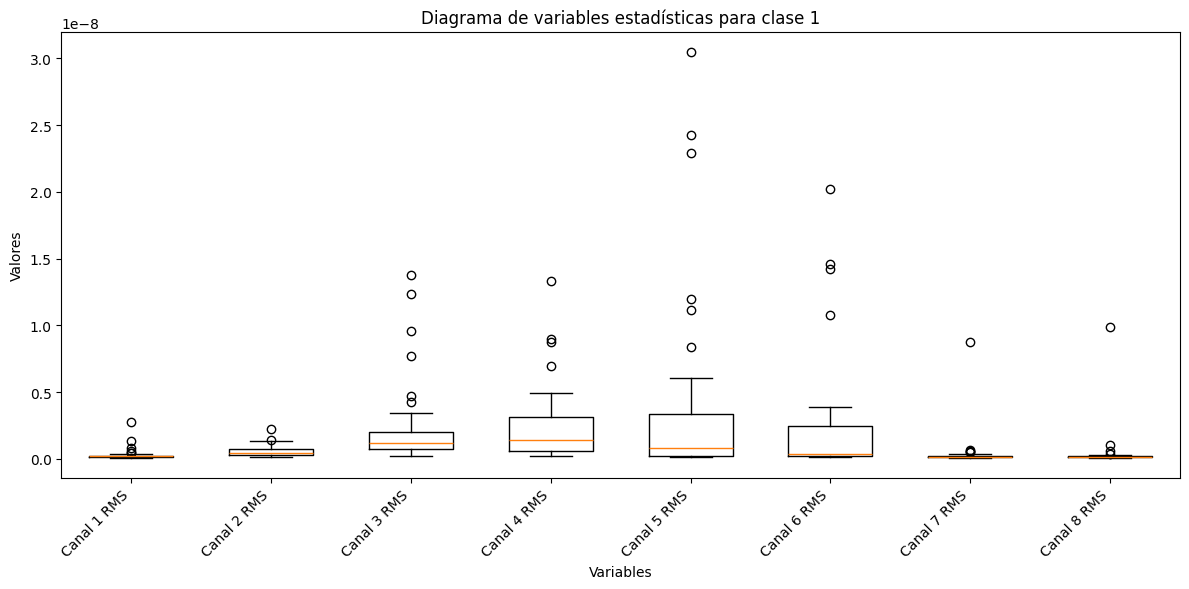

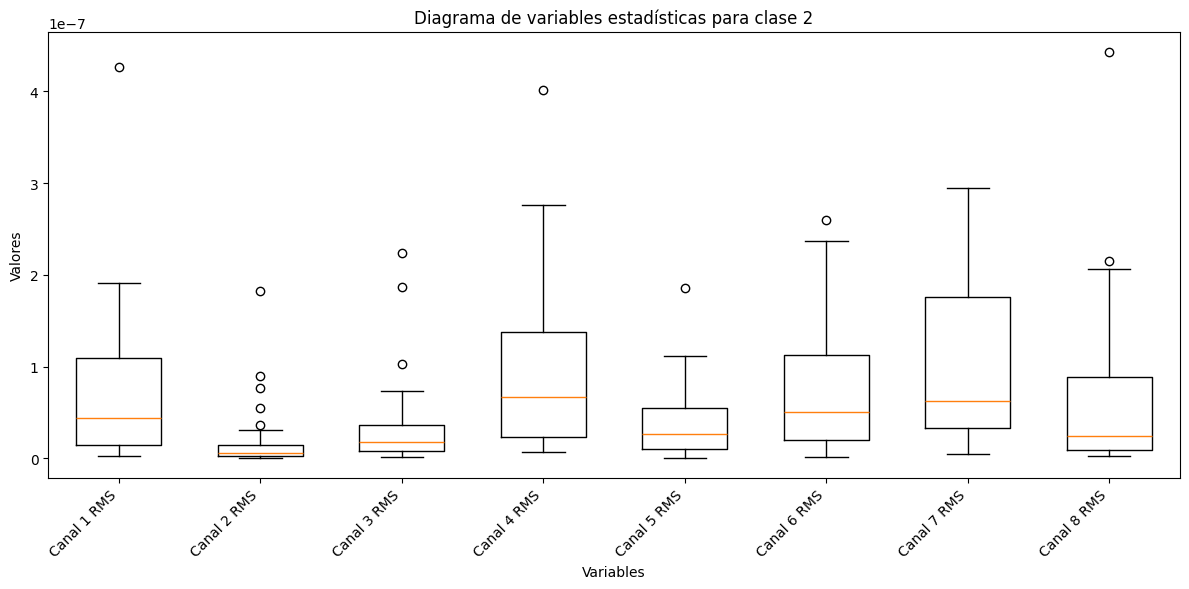

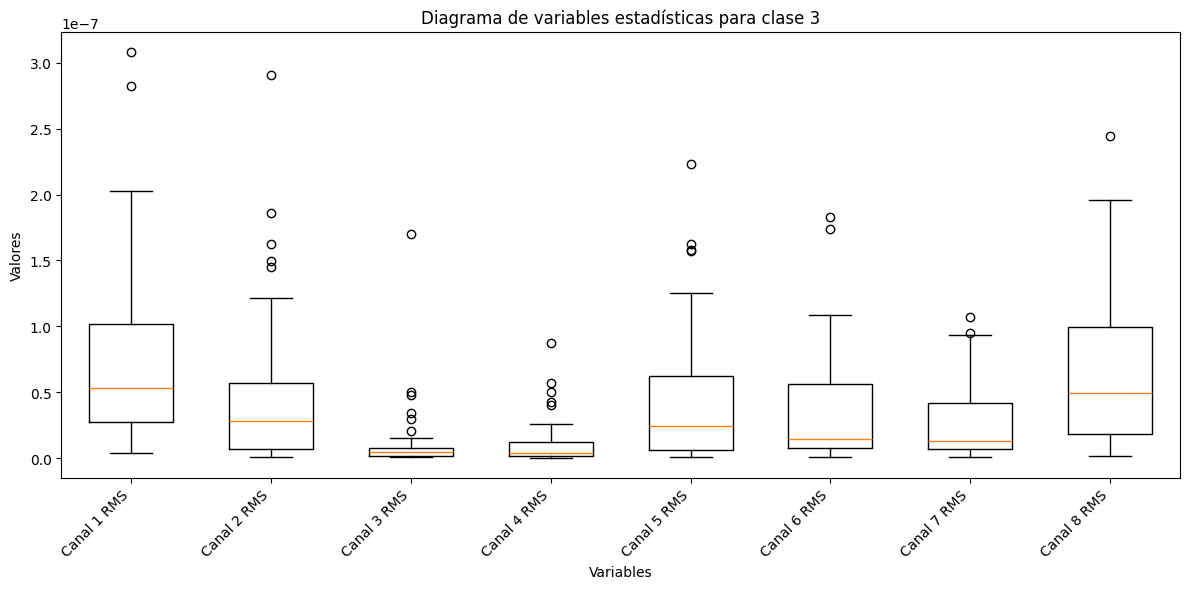

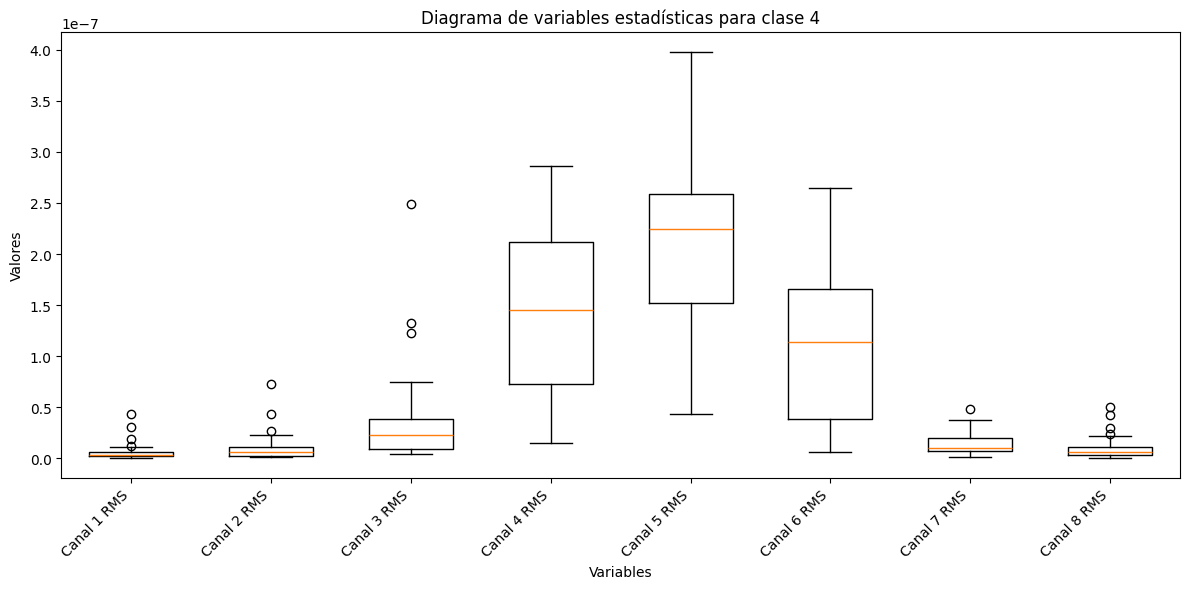

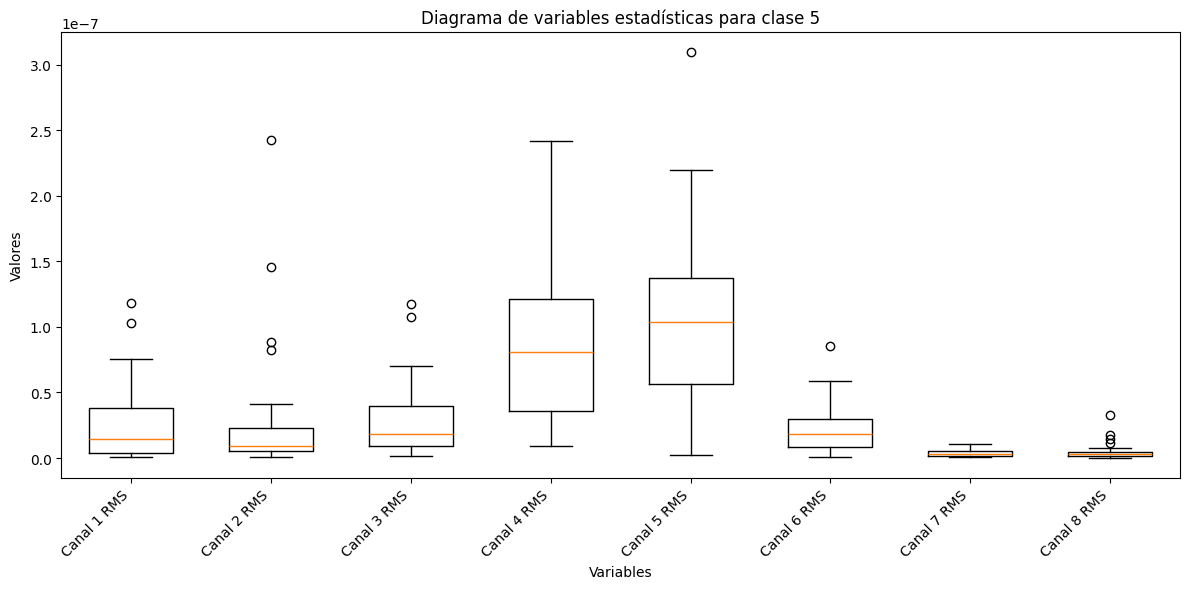

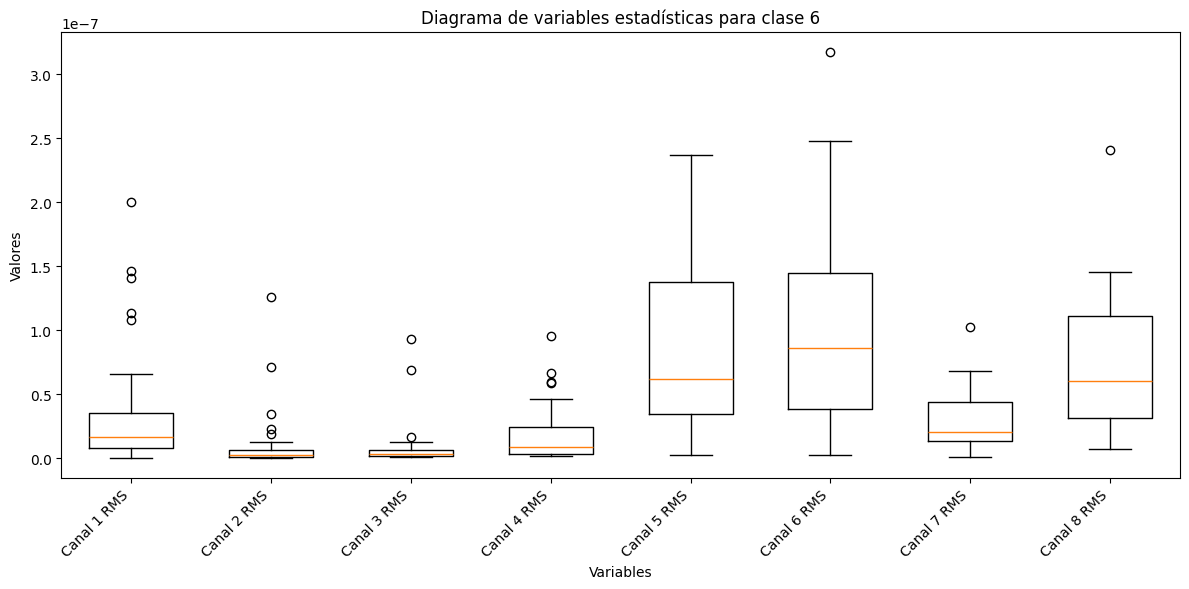

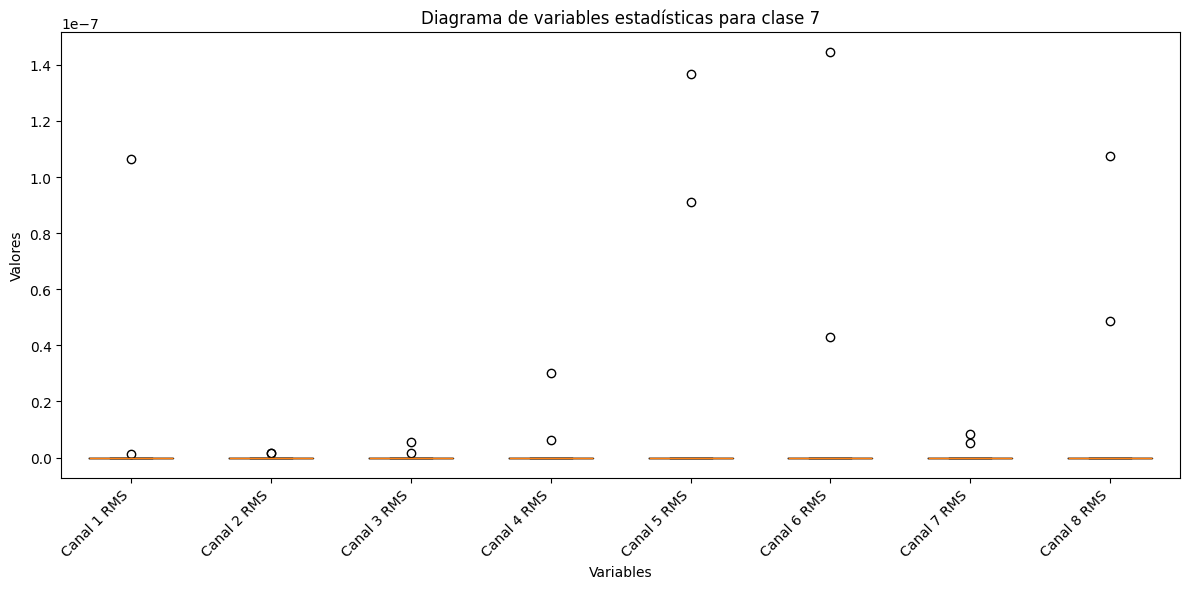

In [340]:

estadisticas = ['RMS', 'Var', 'MAV', 'MAVS', 'SSC', 'WL', 'ZC']
posiciones = np.arange(1, 58)  # Asegúrate de que el tamaño de posiciones sea correcto

for j in range(1, 9):
    lista_RMSc1 = np.array(df_final_Tkeo_mov1[f'C_{j}RMS'])
    lista_canales = []
    
    for i in range(8):
        df_final_Tkeo_mov1 = df_final_Tkeo[df_final_Tkeo['class'] == i]
        lista_canales.append(lista_RMSc1)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bplot1 = ax.boxplot(lista_canales, positions=posiciones[:len(lista_canales)], widths=0.6)
    ax.set_xticks(posiciones[:len(lista_canales)])
    ax.set_xticklabels([f'Canal {j} {estadisticas[0]}' for j in range(1, 9)], rotation=45, ha='right')

    ax.set_title(f'Diagrama de variables estadísticas para clase {i}')
    ax.set_xlabel('Variables')
    ax.set_ylabel('Valores')

    plt.tight_layout()
    plt.show()


In [333]:
df_final_Tkeo_mov1 = df_final_Tkeo[df_final_Tkeo['class']==1]
df_final_Tkeo_mov1

,Sujeto,class,C_1RMS,C_1Var,C_1MAV,C_1MAVS,C_1SSC,C_1WL,C_1ZC,C_2RMS,...,C_7SSC,C_7WL,C_7ZC,C_8RMS,C_8Var,C_8MAV,C_8MAVS,C_8SSC,C_8WL,C_8ZC
1,1,1,2.036246e-10,4.021190e-20,4.505291e-11,7.700450e-11,1150.0,2.910000e-07,0.0,6.175412e-10,...,1123.0,2.062000e-07,1.0,1.452875e-10,2.042391e-20,3.373016e-11,5.856047e-11,1181.0,2.213000e-07,-1.0
1,2,1,2.335839e-10,5.266020e-20,5.120112e-11,8.371053e-11,1158.0,2.996000e-07,0.0,5.507182e-10,...,1158.0,3.344000e-07,0.0,1.792520e-10,3.107594e-20,4.120112e-11,6.890193e-11,1132.0,2.466000e-07,0.0
1,3,1,4.107904e-10,1.632863e-19,8.794051e-11,1.373868e-10,993.0,4.248000e-07,-1.0,1.313259e-09,...,927.0,2.049000e-07,-1.0,2.644468e-10,6.682529e-20,6.964113e-11,1.086999e-10,1037.0,3.361000e-07,1.0
1,4,1,2.438791e-10,5.744274e-20,5.499208e-11,8.281547e-11,990.0,2.612000e-07,0.0,4.102915e-10,...,980.0,2.996000e-07,0.0,2.224913e-10,4.734329e-20,5.496038e-11,8.211795e-11,982.0,2.590000e-07,0.0
1,5,1,3.193126e-10,1.005215e-19,4.791183e-11,8.030171e-11,994.0,2.768000e-07,0.0,4.827806e-10,...,950.0,1.568000e-07,0.0,1.274186e-10,1.564763e-20,3.196056e-11,5.216130e-11,994.0,1.798000e-07,0.0
1,6,1,2.197847e-10,4.647905e-20,5.069260e-11,7.930425e-11,971.0,2.690000e-07,-1.0,7.118238e-10,...,1021.0,2.534000e-07,-1.0,1.520273e-10,2.231842e-20,3.607427e-11,6.223467e-11,1009.0,2.111000e-07,-1.0
1,7,1,2.791135e-09,7.562945e-18,5.239884e-10,7.982654e-10,1192.0,3.037400e-06,0.0,5.054381e-10,...,1086.0,2.000000e-07,0.0,2.092388e-10,4.222139e-20,4.921177e-11,7.700394e-11,1102.0,2.930000e-07,0.0
1,8,1,1.569510e-10,2.400624e-20,3.256475e-11,5.402844e-11,908.0,1.710000e-07,0.0,2.694371e-10,...,902.0,1.508000e-07,0.0,1.207735e-10,1.412220e-20,2.975363e-11,5.067930e-11,930.0,1.604000e-07,0.0
1,9,1,1.664139e-10,2.676819e-20,3.921460e-11,6.329184e-11,994.0,2.288000e-07,0.0,9.681273e-10,...,966.0,2.032000e-07,0.0,5.929154e-10,3.483284e-19,6.814159e-11,1.039004e-10,1012.0,3.756000e-07,0.0
1,10,1,3.465270e-10,1.170407e-19,6.768608e-11,1.014170e-10,1445.0,4.509000e-07,-1.0,8.725404e-10,...,1313.0,2.603000e-07,-1.0,1.634805e-10,2.568169e-20,4.072408e-11,6.666667e-11,1374.0,2.964000e-07,0.0
